# Integrated CA1

## Importing modules

In [1]:
#!pip install pyspark
#!pip install matplotlib
#!pip install seaborn
#!pip install torch
#!pip install scikit-learn

## SparkSession initialisation

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("Integrated CA1 Processing") \
        .getOrCreate()

24/04/07 14:23:33 WARN Utils: Your hostname, BDSP resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/04/07 14:23:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/07 14:23:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## CSV reading

In [3]:
df1 = spark.read.csv("hdfs://localhost:9000/integratedCA1/part1.csv", header=True, inferSchema=True)
df2 = spark.read.csv("hdfs://localhost:9000/integratedCA1/part2.csv", header=True, inferSchema=True)
df3 = spark.read.csv("hdfs://localhost:9000/integratedCA1/part3.csv", header=True, inferSchema=True)

## Merging dataframes

In [4]:
df = df1.union(df2).union(df3)

df.show(5)

+--------+-----------------+-----------------+---------+----------+------------+--------------+
| SQLDATE|Actor1CountryCode|Actor2CountryCode|EventCode|EventCount|TotalSources|PartitionGroup|
+--------+-----------------+-----------------+---------+----------+------------+--------------+
|20110204|              GBR|              EGY|      010|        10|          12|             1|
|20110914|              HND|              AUS|      042|         2|          46|             1|
|20110210|              MEX|              FRA|      120|        10|          46|             1|
|20110427|              ITA|              SYR|      020|        13|          27|             1|
|20110705|              EUR|              GRC|      130|         4|          14|             1|
+--------+-----------------+-----------------+---------+----------+------------+--------------+
only showing top 5 rows



## Exploratory data analysis & Data preparation

In [5]:
df.count()

56976039

In [6]:
df.printSchema()

root
 |-- SQLDATE: integer (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- EventCode: string (nullable = true)
 |-- EventCount: integer (nullable = true)
 |-- TotalSources: integer (nullable = true)
 |-- PartitionGroup: integer (nullable = true)



In [7]:
from pyspark.sql.functions import col, count, isnan, when

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+-----------------+-----------------+---------+----------+------------+--------------+
|SQLDATE|Actor1CountryCode|Actor2CountryCode|EventCode|EventCount|TotalSources|PartitionGroup|
+-------+-----------------+-----------------+---------+----------+------------+--------------+
|      0|                0|                0|        0|         0|           0|             0|
+-------+-----------------+-----------------+---------+----------+------------+--------------+



### Check what data is in PartitionGroup

In [8]:
df.select("PartitionGroup").distinct().count()

3

### Drop PartitionGroup as useless

In [9]:
df = df.drop("PartitionGroup")

## Data filtering

#### Collecting data I mentioned that GDELT Events dataset has a lot of information about events newer exist. Usually they had very few sources.

In [10]:
source_counts = df.groupBy("TotalSources").count().orderBy("TotalSources")

In [11]:
pandas_source_counts = source_counts.toPandas()

In [12]:
pandas_source_counts

,TotalSources,count
0,1,18591873
1,2,16436795
2,3,7167315
3,4,4043456
4,5,1795733
...,...,...
2365,5971,1
2366,6524,1
2367,7032,1
2368,7420,1


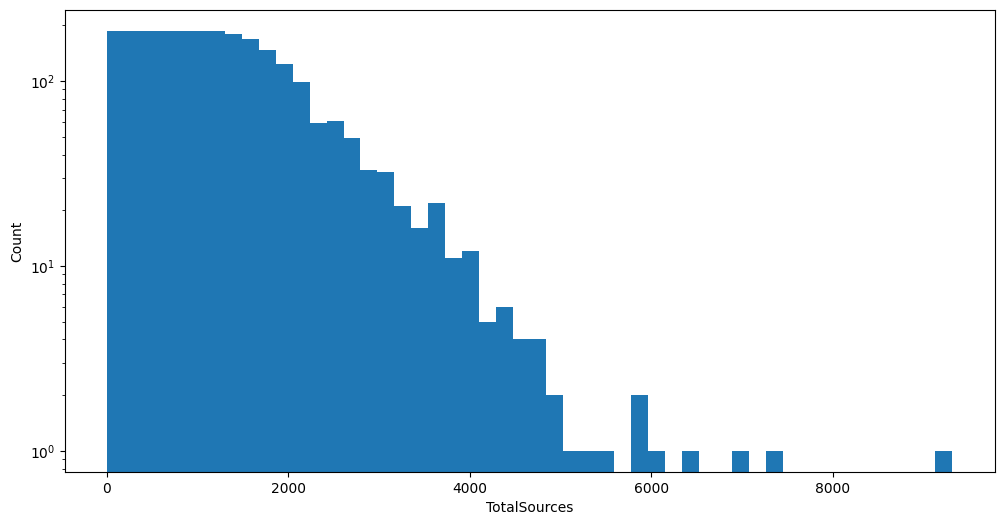

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.hist(pandas_source_counts["TotalSources"], bins=50, log=True)  # Using log scale to show source counts
plt.xlabel("TotalSources")
plt.ylabel("Count")
plt.show()

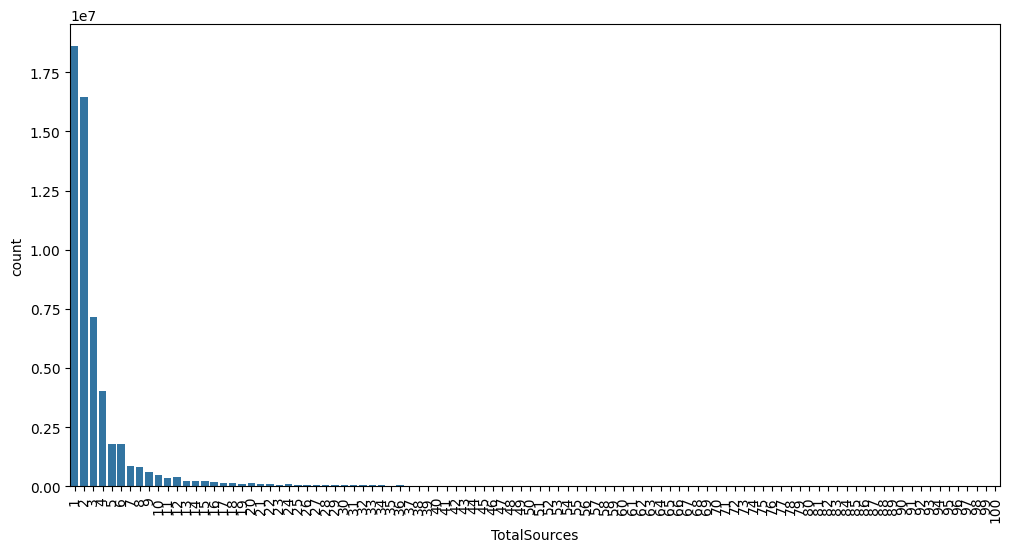

In [16]:
filtered_counts = pandas_source_counts[pandas_source_counts["TotalSources"] <= 100]

plt.figure(figsize=(12, 6))
sns.barplot(x="TotalSources", y="count", data=filtered_counts)
plt.xticks(rotation=90)
plt.show()

#### Setting minimum ampunt of sources will lead to dramatic decrease of events, but still leave enough of events to train the model

In [17]:
minSources = 36
filtered_df = df.filter(df.TotalSources >= minSources)

In [18]:
filtered_df.count()

1295711

#### Another my insight about fake events was that a lot of them was very "general" and their event codes were ending on '0' (such as 010, 190, etc). These events are also non informative enough for thaining models, so lets filter them too

In [ ]:
from pyspark.sql.functions import col

filtered_df = filtered_df.filter(~col("EventCode").rlike(".+0$"))
filtered_df.show()

In [20]:
filtered_df.count()

819196

## Data Preparation

### Feature extraction

In [21]:
from pyspark.sql.functions import col, when

dataframe = filtered_df.withColumn("IsConflict", when(col("EventCode").startswith("19") | col("EventCode").startswith("20"), 1).otherwise(0))

In [22]:
dataframe.show()

+--------+-----------------+-----------------+---------+----------+------------+----------+
| SQLDATE|Actor1CountryCode|Actor2CountryCode|EventCode|EventCount|TotalSources|IsConflict|
+--------+-----------------+-----------------+---------+----------+------------+----------+
|20110914|              HND|              AUS|      042|         2|          46|         0|
|20110901|              GBR|              IRQ|      042|         3|          42|         0|
|20101204|              USA|              KOR|      046|        29|          78|         0|
|20110925|              CUB|              USA|      042|        20|          74|         0|
|20101231|              IRQ|              EGY|      138|         3|          84|         0|
|20110529|              USA|              SAU|      012|         8|          41|         0|
|20101029|              VNM|              JPN|      036|        18|          40|         0|
|20101214|              ISR|              PSE|      036|        10|          39|

### Converting date into timestamp

In [23]:
from pyspark.sql.functions import to_date, unix_timestamp, col

dataframe = dataframe.withColumn('timestamp', unix_timestamp(to_date(col('SQLDATE'), 'yyyyMMdd')))

### Timestamp standartization

In [24]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev

mean_val, std_val = dataframe.select(
    _mean(col('timestamp')).alias('mean'),
    _stddev(col('timestamp')).alias('std')
).first()

dataframe = dataframe.withColumn('timestamp_scaled', (col('timestamp') - mean_val) / std_val)

In [25]:
dataframe.show()

+--------+-----------------+-----------------+---------+----------+------------+----------+----------+-------------------+
| SQLDATE|Actor1CountryCode|Actor2CountryCode|EventCode|EventCount|TotalSources|IsConflict| timestamp|   timestamp_scaled|
+--------+-----------------+-----------------+---------+----------+------------+----------+----------+-------------------+
|20110914|              HND|              AUS|      042|         2|          46|         0|1315954800| -1.136266862141451|
|20110901|              GBR|              IRQ|      042|         3|          42|         0|1314831600|-1.1432547691864292|
|20101204|              USA|              KOR|      046|        29|          78|         0|1291420800|-1.2889033573707038|
|20110925|              CUB|              USA|      042|        20|          74|         0|1316905200| -1.130354017718777|
|20101231|              IRQ|              EGY|      138|         3|          84|         0|1293753600|-1.2743900119695952|
|20110529|      

### Drop unnecessary columns

In [26]:
dataframe = dataframe.drop('SQLDATE', 'timestamp')
dataframe.show()

+-----------------+-----------------+---------+----------+------------+----------+-------------------+
|Actor1CountryCode|Actor2CountryCode|EventCode|EventCount|TotalSources|IsConflict|   timestamp_scaled|
+-----------------+-----------------+---------+----------+------------+----------+-------------------+
|              HND|              AUS|      042|         2|          46|         0| -1.136266862141451|
|              GBR|              IRQ|      042|         3|          42|         0|-1.1432547691864292|
|              USA|              KOR|      046|        29|          78|         0|-1.2889033573707038|
|              CUB|              USA|      042|        20|          74|         0| -1.130354017718777|
|              IRQ|              EGY|      138|         3|          84|         0|-1.2743900119695952|
|              USA|              SAU|      012|         8|          41|         0|-1.1943202437458857|
|              VNM|              JPN|      036|        18|          40|  

### Categorical data vectorization

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexing
actor1Indexer = StringIndexer(inputCol="Actor1CountryCode", outputCol="Actor1CountryCodeIndex")
actor2Indexer = StringIndexer(inputCol="Actor2CountryCode", outputCol="Actor2CountryCodeIndex")
eventIndexer = StringIndexer(inputCol="EventCode", outputCol="EventCodeIndex")

# One-hot encoding
actor1Encoder = OneHotEncoder(inputCol="Actor1CountryCodeIndex", outputCol="Actor1CountryCodeVec")
actor2Encoder = OneHotEncoder(inputCol="Actor2CountryCodeIndex", outputCol="Actor2CountryCodeVec")
eventEncoder = OneHotEncoder(inputCol="EventCodeIndex", outputCol="EventCodeVec")

pipeline = Pipeline(stages=[actor1Indexer, actor2Indexer, eventIndexer, actor1Encoder, actor2Encoder, eventEncoder])

model = pipeline.fit(dataframe)
transformed_df = model.transform(dataframe)

In [28]:
transformed_df.show()

+-----------------+-----------------+---------+----------+------------+----------+-------------------+----------------------+----------------------+--------------+--------------------+--------------------+----------------+
|Actor1CountryCode|Actor2CountryCode|EventCode|EventCount|TotalSources|IsConflict|   timestamp_scaled|Actor1CountryCodeIndex|Actor2CountryCodeIndex|EventCodeIndex|Actor1CountryCodeVec|Actor2CountryCodeVec|    EventCodeVec|
+-----------------+-----------------+---------+----------+------------+----------+-------------------+----------------------+----------------------+--------------+--------------------+--------------------+----------------+
|              HND|              AUS|      042|         2|          46|         0| -1.136266862141451|                  89.0|                  15.0|           0.0|    (217,[89],[1.0])|    (217,[15],[1.0])| (223,[0],[1.0])|
|              GBR|              IRQ|      042|         3|          42|         0|-1.1432547691864292|      